# Sparse reduced-rank regression for exploratory visualization<br>of Patch-seq recordings

### *Dmitry Kobak, Yves Bernaerts, Marissa A. Weis, and Philipp Berens*

https://www.biorxiv.org/content/10.1101/302208

<img src="figure-rrr.png"  alt="Sparse reduced-rank regression for patch-seq data">

The loss function for reduced-rank regression with elastic net penalty:

$$\mathcal L = \lVert \mathbf Y - \mathbf X \mathbf W \mathbf V^\top\rVert^2 + \lambda \Big(\alpha \sum_{i=1}^p\lVert \mathbf W_{i\cdot}\rVert_2 + (1-\alpha) \lVert \mathbf W \rVert^2\Big) \;\;\;\text{s.t.}\; \mathbf V^\top\mathbf V = \mathbf I.$$

In [2]:
%matplotlib notebook

import numpy as np
import pylab as plt
import seaborn as sns; sns.set()
import pandas as pd
import pickle
from scipy import io
import matplotlib

import glmnet_python
from glmnet import glmnet

# Two .py files in this directory
import sparseRRR
import spls_scca

# This file is from https://github.com/berenslab/rna-seq-tsne
import sys; sys.path.append('../rna-seq-tsne/')
import rnaseqTools

def sns_styleset():
    sns.set_context('paper')
    sns.set_style('ticks')
    matplotlib.rcParams['axes.linewidth']    = .75
    matplotlib.rcParams['xtick.major.width'] = .75
    matplotlib.rcParams['ytick.major.width'] = .75
    matplotlib.rcParams['xtick.major.size'] = 3
    matplotlib.rcParams['ytick.major.size'] = 3
    matplotlib.rcParams['xtick.minor.size'] = 2
    matplotlib.rcParams['ytick.minor.size'] = 2
    matplotlib.rcParams['font.size']       = 7
    matplotlib.rcParams['axes.titlesize']  = 7
    matplotlib.rcParams['axes.labelsize']  = 7
    matplotlib.rcParams['legend.fontsize'] = 7
    matplotlib.rcParams['xtick.labelsize'] = 7
    matplotlib.rcParams['ytick.labelsize'] = 7

## Scala et al. dataset

In [3]:
# Load the data

data = pd.read_csv("../../BICCN patch-seq data/L4/rnaseq/counts.csv", sep='\t')
counts = data.values[:,1:].transpose().astype(float)
genes = data.values[:,0]
cells = np.array(data.columns[1:])

print('Number of cells: {}\nNumber of genes: {}'.format(counts.shape[0], counts.shape[1]))

meta = pd.read_excel('../../BICCN patch-seq data/L4/Layer 4 cells.xlsx', index_col=0)
d = [d[6:10]+d[:2]+d[3:5] for d in meta.values[1:,1] if d is not np.nan]
s = [s[7:].strip() if 'sample ' in s else s[6:].strip() for s in meta.values[1:,2] if s is not np.nan]
names = [d[i]+'_sample_'+s[i] for i in range(len(d))]
regions = [m for m in meta.values[1:,3] if m=='V1' or m=='S1']
layers = [m for m in meta.values[1:,4] if ~np.isnan(m)]
names2regions = dict(zip(names,regions))
names2layers = dict(zip(names,layers))

regions = np.array([names2regions['_'.join(c.split('_')[:3])] for c in cells])
layers  = np.array([names2layers['_'.join(c.split('_')[:3])] for c in cells])

ephysData = pd.read_csv('../layer4/ephys/data/patch-seq-ephys-features.csv')
ephysNames = np.array(ephysData.columns[1:-2])
ephysCells = np.array([s.split('sample')[0]+'_sample_'+s.split('sample')[1] for s in ephysData.values[:,0]])
keep = ephysData['Good quality']
ai0 = ephysData['AI']==0
ephysData = ephysData.values[:, 1:-2].astype('float')
ephysData[~keep,:] = np.nan
ephysData[keep, ephysNames=='Latency (ms)'] = np.log(ephysData[keep, ephysNames=='Latency (ms)'])
ephysData[keep & ~ai0, ephysNames=='AI'] = np.log(ephysData[keep & ~ai0, ephysNames=='AI']/100)
ephysData[ai0, ephysNames=='AI'] = np.nan
names2ephys = dict(zip(ephysCells, ephysData))
ephys = np.array([names2ephys['_'.join(c.split('_')[:3])] if '_'.join(c.split('_')[:3]) in names2ephys
          else np.ones(ephysNames.size)*np.nan for c in cells]).astype(float)

l4 = {'counts': counts, 'cells': cells, 'genes': genes, 
      'regions': regions, 'layers': layers, 'ephys': ephys,
      'ephysNames': ephysNames}

print('')
print(ephysNames)
print(ephysNames.size)

Number of cells: 118
Number of genes: 26514

['ADP (mV)' 'AHP (mV)' 'AI' 'AP amplitude (mV)' 'AP threshold (mV)'
 'AP width (ms)' 'Max number of spikes' 'Input R (MOhm)' 'Vm (mV)'
 'Latency (ms)' 'Rheobase (pA)' 'Sag ratio' 'Tau (ms)']
13


In [4]:
np.sum(np.sum(l4['counts'], axis=0)>0)

17862

Chosen offset: 7.08


<IPython.core.display.Javascript object>


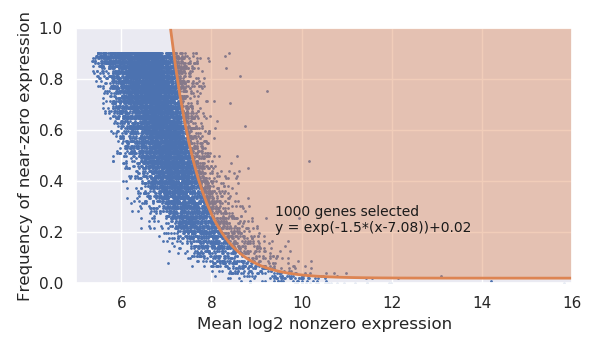

Shape of X: (102, 1000) 
Shape of Y: (102, 13)


In [36]:
# cells to exclude based on RNA (either low quality or maps to PV/excitatory
exclude = ['20180605_sample_12_L4_S109', '20180626_sample_11_L4_S129',
           '20180703_sample_6_L4_S157', '20180919_sample_21_L4_S136',
           '20180605_sample_17_L4_S114', '20180626_sample_7_L4_S125',
           '20180627_sample_1_L4_S137', '20180703_sample_4_L4_S154']

selection = ~np.isin(l4['cells'], exclude) & ~np.isnan(np.sum(l4['ephys'],axis=1))

genesForRRR = rnaseqTools.geneSelection(l4['counts'][selection,:], n=1000, threshold=32)

X = l4['counts'][selection,:] / np.sum(l4['counts'][selection,:], axis=1, keepdims=True) * 1e+6
X = np.log2(X + 1)
X = X[:, genesForRRR]
X = X - np.mean(X, axis=0)
X = X / np.std(X, axis=0)

Y = l4['ephys'][selection,:]
Y = Y - np.mean(Y, axis=0)
Y = Y / np.std(Y, axis=0)

print('Shape of X:', X.shape, '\nShape of Y:', Y.shape)

l4['selection'] = selection
l4['genesForRRR'] = genesForRRR
l4['X'] = X
l4['Y'] = Y

1.......... Time: 0.0h  0m 48s


<IPython.core.display.Javascript object>


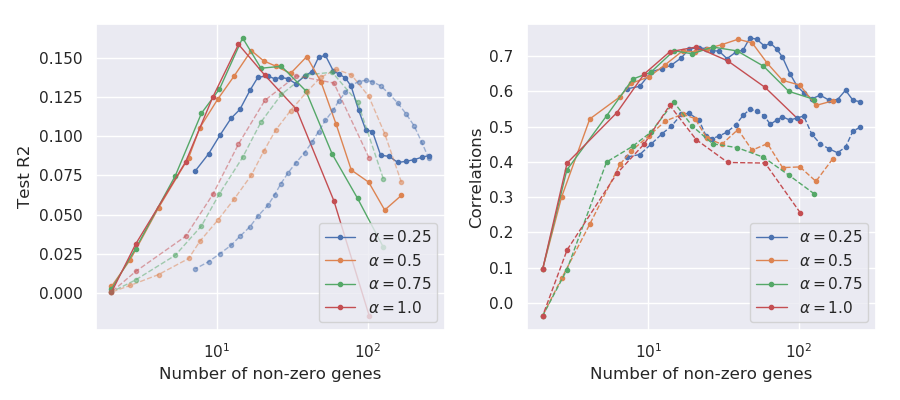

In [6]:
# sRRR cross-validatation

lambdas = np.concatenate([np.arange(.1,3,.1), np.arange(3,11)])
alphas = np.array([.25, .5, .75, 1])

cvResults = sparseRRR.elastic_rrr_cv(X, Y, rank=2, reps=1, folds=10, alphas=alphas, lambdas=lambdas)

sparseRRR.plot_cv_results(*cvResults, alphas)

Genes selected: 20


<IPython.core.display.Javascript object>


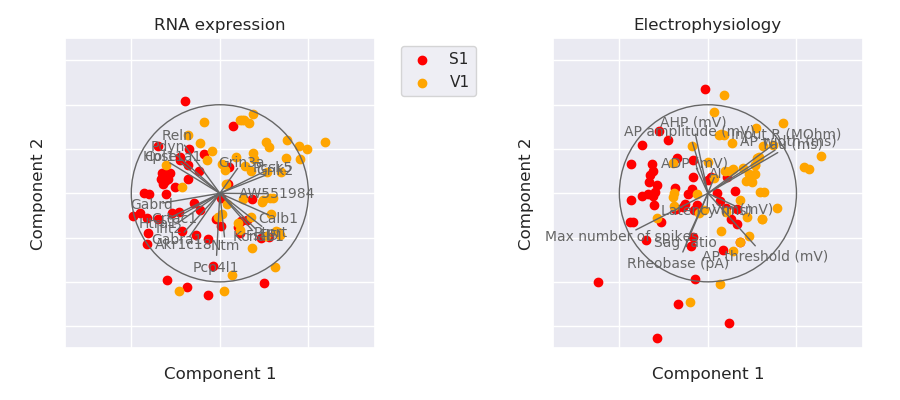

In [7]:
# sRRR bibiplot

w,v = sparseRRR.relaxed_elastic_rrr(X, Y, rank=2, lambdau=.95, alpha=.5)
print('Genes selected: {}'.format(np.sum(w[:,0]!=0)))

sparseRRR.bibiplot(X, Y, w, v, 
                   titles=['RNA expression', 'Electrophysiology'],
                   cellTypes=l4['regions'][selection], 
                   cellTypeColors={'V1':'orange','S1':'red'}, 
                   cellTypeLabels = {'V1':'V1','S1':'S1'}, 
                   YdimsNames=l4['ephysNames'], XdimsNames=l4['genes'][genesForRRR],
                   xylim = 3.5)

1.......... Time: 0.0h  1m 35s


<IPython.core.display.Javascript object>


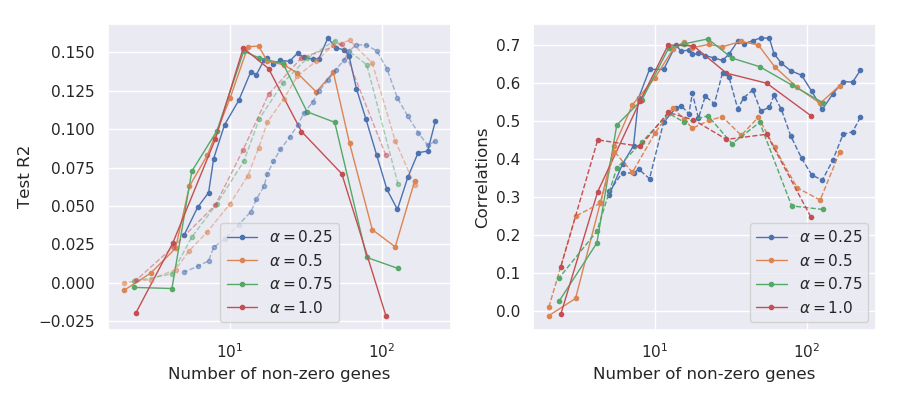

Genes selected for component 1: 10
Genes selected for component 2: 7
Genes selected for component 1 after relaxation: 17
Genes selected for component 2 after relaxation: 17


<IPython.core.display.Javascript object>


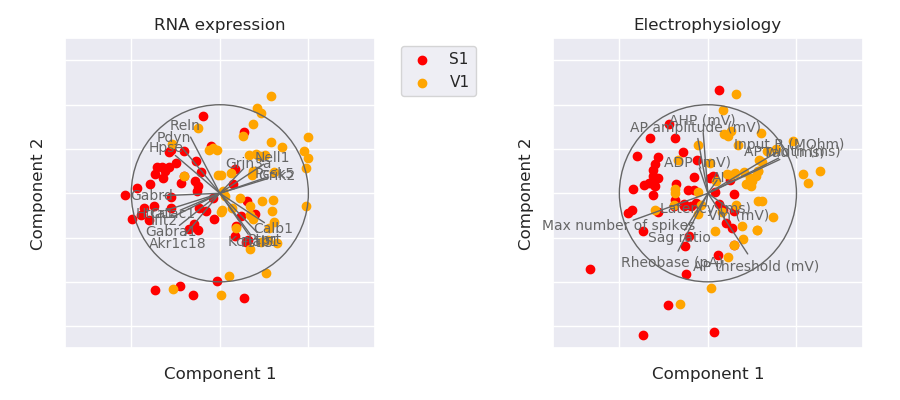

In [37]:
# Cross-validatation and bibiplot using cell-wise (not row-wise) sparsity

cvResults = sparseRRR.elastic_rrr_cv(X, Y, rank=2, reps=1, folds=10, alphas=alphas, lambdas=lambdas,
                                     sparsity='cell-wise')
sparseRRR.plot_cv_results(*cvResults, alphas)

w,v = sparseRRR.elastic_rrr(X, Y, rank=2, lambdau=.95, alpha=.5, sparsity='cell-wise')
print('Genes selected for component 1: {}'.format(np.sum(w[:,0]!=0)))
print('Genes selected for component 2: {}'.format(np.sum(w[:,1]!=0)))

w,v = sparseRRR.relaxed_elastic_rrr(X, Y, rank=2, lambdau=.95, alpha=.5, sparsity='cell-wise')
print('Genes selected for component 1 after relaxation: {}'.format(np.sum(w[:,0]!=0)))
print('Genes selected for component 2 after relaxation: {}'.format(np.sum(w[:,1]!=0)))


sparseRRR.bibiplot(X, Y, w, v, 
                   titles=['RNA expression', 'Electrophysiology'],
                   cellTypes=l4['regions'][selection], 
                   cellTypeColors={'V1':'orange','S1':'red'}, 
                   cellTypeLabels = {'V1':'V1','S1':'S1'}, 
                   YdimsNames=l4['ephysNames'], XdimsNames=l4['genes'][genesForRRR],
                   xylim = 3.5)

In [328]:
# Gene selection stability

bootCounts = sparseRRR.elastic_rrr_bootstrap(X, Y, rank=2, lambdau=.95, alpha=.5)

for ii in np.argsort(bootCounts)[::-1][:20]:
    print('{:10} {:.2f}'.format(l4['genes'][genesForRRR][ii], bootCounts[ii]))

.................................................................................................... 
Htra1      0.89
Akr1c18    0.83
Gabrd      0.79
Reln       0.75
Ifit2      0.73
Pdyn       0.73
Fstl5      0.70
Calb1      0.68
Gabra1     0.63
AW551984   0.53
Pgrmc1     0.44
Grin3a     0.44
Ptprt      0.44
Ntm        0.38
Col11a1    0.37
Grik2      0.36
Pcsk5      0.35
Camkv      0.32
Pgap1      0.31
Hpse       0.30


<IPython.core.display.Javascript object>


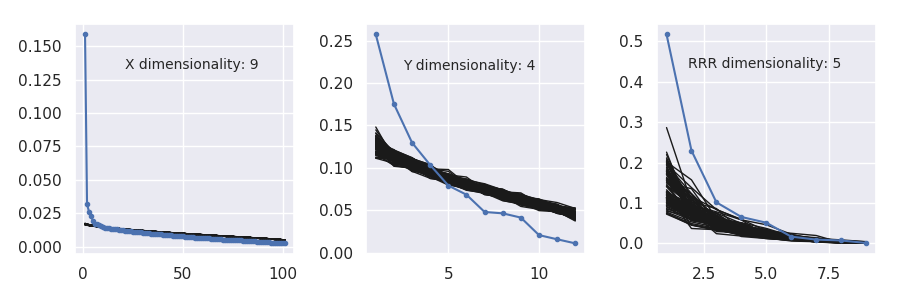

In [255]:
sparseRRR.dimensionality(X, Y)

## Cadwell et al. dataset

In [23]:
# Load the data

data = pd.read_excel('cadwellData/Data_CortexInterneurons.xlsx', sheet_name="readcounts")
cells  = np.array([int(c[5:-1]) for c in data.values[2,2:-5]])
genes  = np.array([c[1:-1] for c in data.values[4:,1]])
counts = data.values[4:,2:-5].T.astype('float')

print('Number of cells: {}\nNumber of genes: {}'.format(counts.shape[0], counts.shape[1]))

varGenes = pd.read_excel('https://media.nature.com/original/nature-assets/nbt/journal/v34/n2/extref/nbt.3445-S3.xlsx')
varGenes = varGenes.values[3:,-1]
varGenes = np.array([g[1:-1] for g in varGenes])
lgenes = list(genes)
counts = counts[:, [lgenes.index(g) for g in varGenes]]

from scipy import io
mat = io.loadmat('cadwellData/IntPhysiologyFinal.mat')
types = np.array([mat['cell'][0][n][3][0][0] for n in range(len(mat['cell'][0]))])
idxs  = np.array([mat['cell'][0][n][0][0][0] for n in range(len(mat['cell'][0]))])

cols = [2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
ephysNames = np.array(['V_rest', 'R_input', 'AP tau', 'AP thresh', 'AP width', 'AP amp', 'AHP', 'ADP', 
                   'Adapt', 'ifDelayed', 'ifBurst'])
ephys = np.zeros((idxs.size, len(cols)))
for j,c in enumerate(cols):
    ephys[:,j] = [mat['cell'][0][i][c][0][0] for i in range(len(mat['cell'][0]))]

# Int_44 and Int_45 were removed from the Cadwell et al. due to possible contamination
keep = (idxs != 44) & (idxs != 45) & ~np.isnan(np.sum(ephys,axis=1))
types = types[keep]
idxs  =  idxs[keep]
ephys = ephys[keep]
counts = counts[[np.where(cells==i)[0][0] for i in idxs], :]

cadwell = {'counts': counts, 'ephys': ephys, 'cellTypes': types, 
           'ephysNames': ephysNames, 'genes': varGenes}

print('Number of cells: {}\nNumber of genes: {}'.format(counts.shape[0], counts.shape[1]))
print('')
print(ephysNames)
print(ephysNames.size)

Number of cells: 62
Number of genes: 21812
Number of cells: 44
Number of genes: 15074

['V_rest' 'R_input' 'AP tau' 'AP thresh' 'AP width' 'AP amp' 'AHP' 'ADP'
 'Adapt' 'ifDelayed' 'ifBurst']
11


In [24]:
# Plotting parameters for Cadwell data

colors = np.zeros((5,3))
colors[0,:] = [217,95,2]
colors[-1,:] = [27,158,119]
for i in range(1,4):
    colors[i,:] = colors[0,:] * (5-i)/4 + colors[-1,:] * i/4
colors = colors/256

cellTypeColors = dict(zip(range(1,6), colors))
cellTypeLabels = dict(zip(range(1,6), ['NGC', None, None, None,'SBC']))

cadwell['colors'] = cellTypeColors
cadwell['labels'] = cellTypeLabels

In [25]:
# Library size normalization and log transform
X = cadwell['counts'] / np.sum(cadwell['counts'], axis=1, keepdims=True) * 1e+6
X = np.log2(X + 1)
X = X[:,:3000]

Y = cadwell['ephys']

# Standardize X
mu = np.mean(X, axis=0)
X = X - mu
sigma = np.std(X, axis=0)
X = X / sigma

# Standardize Y
mu = np.mean(Y, axis=0)
Y = Y - mu
sigma = np.std(Y, axis=0)
Y = Y / sigma

print('Shape of X:', X.shape, '\nShape of Y:', Y.shape)

cadwell['X'] = X
cadwell['Y'] = Y

Shape of X: (44, 3000) 
Shape of Y: (44, 11)


1........... Time: 0.0h  1m 25s


<IPython.core.display.Javascript object>


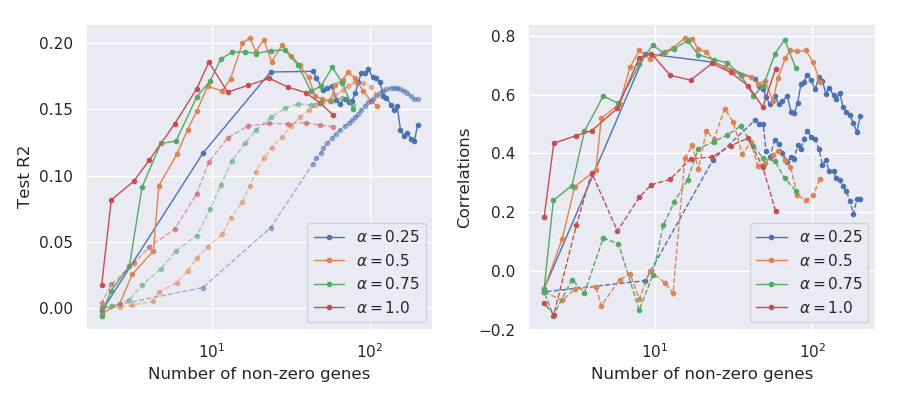

In [38]:
# sRRR cross-validatation

lambdas = np.concatenate([np.arange(.1,3,.1), np.arange(3,11)])
alphas = np.array([.25, .5, .75, 1])

cvResults = sparseRRR.elastic_rrr_cv(X, Y, rank=2, reps=1, folds=11, alphas=alphas, lambdas=lambdas)

sparseRRR.plot_cv_results(*cvResults, alphas)

Number of genes selected: 22


<IPython.core.display.Javascript object>


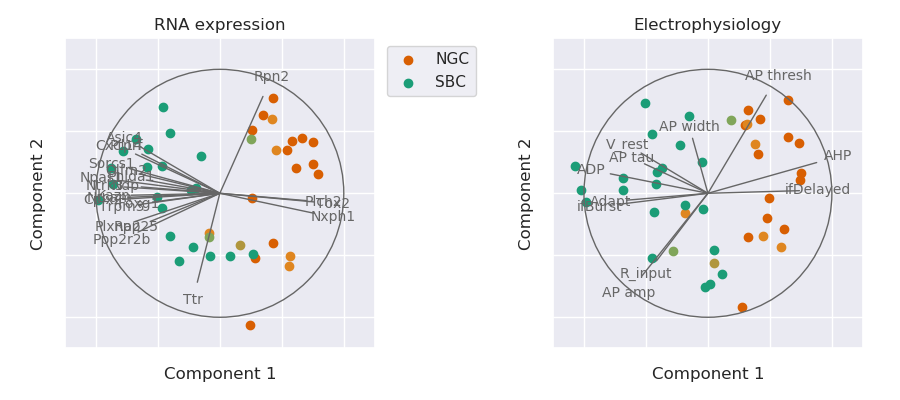

In [37]:
# sRRR bibiplot

w,v = sparseRRR.relaxed_elastic_rrr(X, Y, rank=2, alpha=.5, lambdau=1.5)
print('Number of genes selected: {}'.format(np.sum(w[:,0]!=0)))

sparseRRR.bibiplot(X, Y, w, v, titles=['RNA expression', 'Electrophysiology'],
         cellTypes=cadwell['cellTypes'], cellTypeColors=cadwell['colors'], cellTypeLabels = cadwell['labels'],
         YdimsNames=cadwell['ephysNames'], XdimsNames=cadwell['genes'],
         xylim = 2.5)

1........... Time: 0.0h  2m  5s


<IPython.core.display.Javascript object>


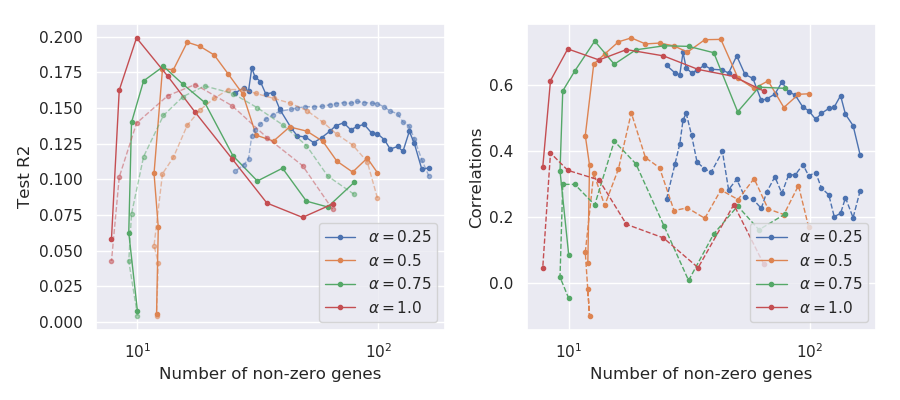

Genes selected for component 1: 12
Genes selected for component 2: 1
Genes selected for component 1 after relaxation: 13
Genes selected for component 2 after relaxation: 13


<IPython.core.display.Javascript object>


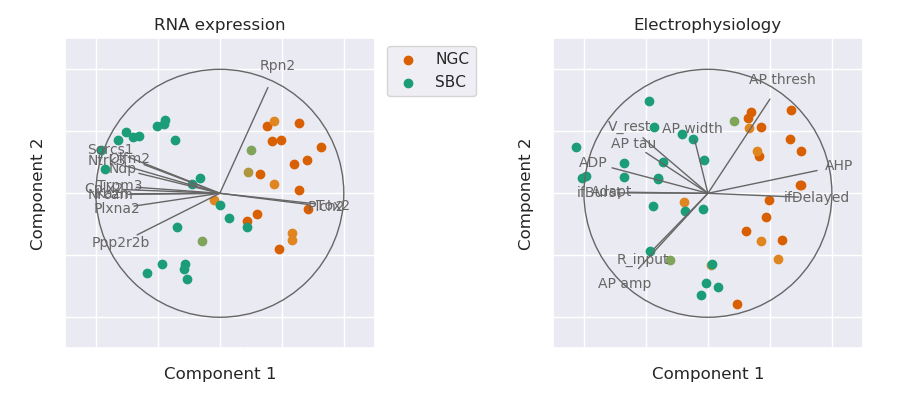

In [35]:
# Cross-validatation and bibiplot using cell-wise (not row-wise) sparsity

cvResults = sparseRRR.elastic_rrr_cv(X, Y, rank=2, reps=1, folds=11, alphas=alphas, lambdas=lambdas,
                                     sparsity='cell-wise')
sparseRRR.plot_cv_results(*cvResults, alphas)

w,v = sparseRRR.elastic_rrr(X, Y, rank=2, lambdau=1.5, alpha=.5, sparsity='cell-wise')
print('Genes selected for component 1: {}'.format(np.sum(w[:,0]!=0)))
print('Genes selected for component 2: {}'.format(np.sum(w[:,1]!=0)))

w,v = sparseRRR.relaxed_elastic_rrr(X, Y, rank=2, lambdau=1.5, alpha=.5, sparsity='cell-wise')
print('Genes selected for component 1 after relaxation: {}'.format(np.sum(w[:,0]!=0)))
print('Genes selected for component 2 after relaxation: {}'.format(np.sum(w[:,1]!=0)))

sparseRRR.bibiplot(X, Y, w, v, titles=['RNA expression', 'Electrophysiology'],
         cellTypes=cadwell['cellTypes'], cellTypeColors=cadwell['colors'], cellTypeLabels = cadwell['labels'],
         YdimsNames=cadwell['ephysNames'], XdimsNames=cadwell['genes'],
         xylim = 2.5)

In [36]:
# Gene selection stability

bootCounts = sparseRRR.elastic_rrr_bootstrap(X, Y, rank=2, lambdau=1.5, alpha=.5)

for ii in np.argsort(bootCounts)[::-1][:20]:
    print('{:10} {:.2f}'.format(cadwell['genes'][ii], bootCounts[ii]))

.................................................................................................... 
Kazn       0.71
Cplx2      0.49
Plch2      0.46
Ntrk3      0.46
Nrcam      0.45
Plxna2     0.42
Ppp2r2b    0.39
Tox2       0.38
Ndp        0.36
Rpn2       0.36
Sorcs1     0.35
Asic4      0.33
Rpp25      0.28
Slamf9     0.27
Trpm3      0.26
Olfm2      0.26
Efcab7     0.25
Col4a1     0.24
Foxg1      0.23
Npas1      0.23


<IPython.core.display.Javascript object>


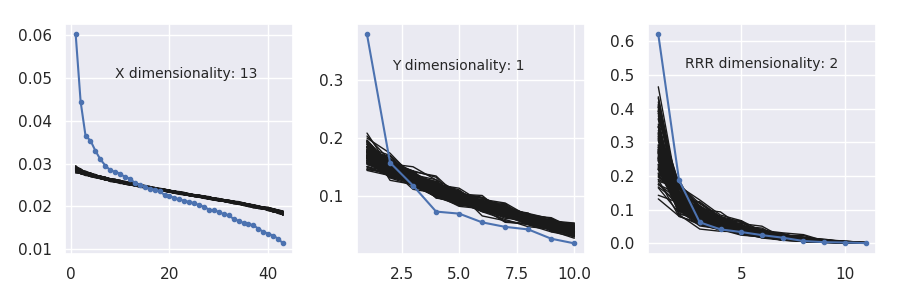

In [257]:
sparseRRR.dimensionality(X, Y)

## FIGURE: PCA of X and Y in both datasets

<IPython.core.display.Javascript object>


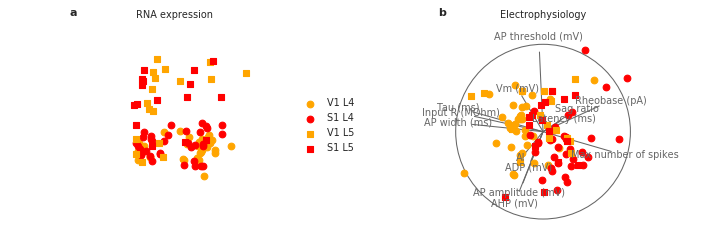

In [251]:
sns_styleset()
plt.figure(figsize=(7.2, 2.5))

#################################

# X = cadwell['X']
# Y = cadwell['Y']

# from sklearn.decomposition import PCA
# Zx = PCA(n_components=2, svd_solver='full').fit_transform(X)  
# Zy = PCA(n_components=2, svd_solver='full').fit_transform(Y)  
# Zx = Zx / np.std(Zx, axis=0)
# Zy = Zy / np.std(Zy, axis=0)
    
# plt.subplot(221, aspect='equal')
# for ct in np.unique(cadwell['cellTypes']):
#     plt.scatter(Zx[cadwell['cellTypes']==ct,0], Zx[cadwell['cellTypes']==ct,1], 
#                 color=cadwell['colors'][ct], zorder=2, label=cadwell['labels'][ct])
# plt.legend(frameon=False, bbox_to_anchor=(1.4, .7))
# plt.ylim([-3.6, 3.6])
# plt.xlim([-3.6, 3.6])
# plt.xticks([])
# plt.yticks([])
# plt.title('RNA expression')

# plt.subplot(222, aspect='equal')
# for ct in np.unique(cadwell['cellTypes']):
#     plt.scatter(Zy[cadwell['cellTypes']==ct,0], Zy[cadwell['cellTypes']==ct,1], 
#                 color=cadwell['colors'][ct], zorder=2)
# plt.ylim([-3.6, 3.6])
# plt.xlim([-3.6, 3.6])
# plt.xticks([])
# plt.yticks([])
# plt.title('Electrophysiology')

# L = np.corrcoef(np.concatenate((Zy[:,:2], Y), axis=1), rowvar=False)[2:,:2]
# for i in range(Y.shape[1]):
#     plt.plot([0, scaleFactor*L[i,0]], [0, scaleFactor*L[i,1]], linewidth=.75, 
#              color=[.4, .4, .4], zorder=1)
#     plt.text(scaleFactor*L[i,0]*1.2, scaleFactor*L[i,1]*1.2, cadwell['ephysNames'][i], 
#              ha='center', va='center', color=[.4, .4, .4], fontsize=7)
# circ = plt.Circle((0,0), radius=scaleFactor, color=[.4, .4, .4], fill=False, linewidth=.75)
# plt.gca().add_patch(circ)

#################################

X = l4['X']
Y = l4['Y']

Zx = PCA(n_components=2, svd_solver='full').fit_transform(X)  
Zy = PCA(n_components=2, svd_solver='full').fit_transform(Y)  
Zx = Zx / np.std(Zx, axis=0)
Zy = Zy / np.std(Zy, axis=0)
    
plt.subplot(121, aspect='equal')
# plt.scatter(Zx[l4['regions'][selection]=='V1',0], Zx[l4['regions'][selection]=='V1',1], 
#             color='orange', zorder=2, label='V1')
# plt.scatter(Zx[l4['regions'][selection]=='S1',0], Zx[l4['regions'][selection]=='S1',1], 
#             color='red', zorder=2, label='S1')
plt.scatter(Zx[(l4['regions'][selection]=='V1')&(l4['layers'][selection]==4),0],
            Zx[(l4['regions'][selection]=='V1')&(l4['layers'][selection]==4),1],
            color='orange', zorder=2, label='V1 L4')
plt.scatter(Zx[(l4['regions'][selection]=='S1')&(l4['layers'][selection]==4),0],
            Zx[(l4['regions'][selection]=='S1')&(l4['layers'][selection]==4),1],
            color='red', zorder=2, label='S1 L4')
plt.scatter(Zx[(l4['regions'][selection]=='V1')&(l4['layers'][selection]==5),0],
            Zx[(l4['regions'][selection]=='V1')&(l4['layers'][selection]==5),1],
            color='orange', zorder=2, label='V1 L5', marker='s')
plt.scatter(Zx[(l4['regions'][selection]=='S1')&(l4['layers'][selection]==5),0],
            Zx[(l4['regions'][selection]=='S1')&(l4['layers'][selection]==5),1],
            color='red', zorder=2, label='S1 L5', marker='s')

plt.legend(frameon=False, bbox_to_anchor=(1.4, .7))
plt.ylim([-3.6, 3.6])
plt.xlim([-3.6, 3.6])
plt.xticks([])
plt.yticks([])
plt.title('RNA expression')

plt.subplot(122, aspect='equal')
# plt.scatter(Zy[l4['regions'][selection]=='V1',0], Zy[l4['regions'][selection]=='V1',1], 
#             color='orange', zorder=2)
# plt.scatter(Zy[l4['regions'][selection]=='S1',0], Zy[l4['regions'][selection]=='S1',1], 
#             color='red', zorder=2)
plt.scatter(Zy[(l4['regions'][selection]=='V1')&(l4['layers'][selection]==4),0],
            Zy[(l4['regions'][selection]=='V1')&(l4['layers'][selection]==4),1],
            color='orange', zorder=2)
plt.scatter(Zy[(l4['regions'][selection]=='S1')&(l4['layers'][selection]==4),0],
            Zy[(l4['regions'][selection]=='S1')&(l4['layers'][selection]==4),1],
            color='red', zorder=2)
plt.scatter(Zy[(l4['regions'][selection]=='V1')&(l4['layers'][selection]==5),0],
            Zy[(l4['regions'][selection]=='V1')&(l4['layers'][selection]==5),1],
            color='orange', zorder=2, marker='s')
plt.scatter(Zy[(l4['regions'][selection]=='S1')&(l4['layers'][selection]==5),0],
            Zy[(l4['regions'][selection]=='S1')&(l4['layers'][selection]==5),1],
            color='red', zorder=2, marker='s')
plt.ylim([-3.6, 3.6])
plt.xlim([-3.6, 3.6])
plt.xticks([])
plt.yticks([])
plt.title('Electrophysiology')

scaleFactor = 3
L = np.corrcoef(np.concatenate((Zy[:,:2], Y), axis=1), rowvar=False)[2:,:2]
for i in range(Y.shape[1]):
    plt.plot([0, scaleFactor*L[i,0]], [0, scaleFactor*L[i,1]], linewidth=.75, color=[.4, .4, .4],
             zorder=1)
    plt.text(scaleFactor*L[i,0]*1.2, scaleFactor*L[i,1]*1.2, l4['ephysNames'][i], 
             ha='center', va='center', color=[.4, .4, .4], fontsize=7)
circ = plt.Circle((0,0), radius=scaleFactor, color=[.4, .4, .4], fill=False, linewidth=.75)
plt.gca().add_patch(circ)

#################################

sns.despine(left=True, bottom=True)
plt.tight_layout()

plt.text(0, 1.05,  'a', transform = plt.gcf().get_axes()[0].transAxes, fontsize=8, fontweight='bold')
plt.text(0, 1.05,  'b', transform = plt.gcf().get_axes()[1].transAxes, fontsize=8, fontweight='bold')
# plt.text(0, 1.05,  'c', transform = plt.gcf().get_axes()[2].transAxes, fontsize=8, fontweight='bold')
# plt.text(0, 1.05,  'd', transform = plt.gcf().get_axes()[3].transAxes, fontsize=8, fontweight='bold')

# plt.gcf().text(.03,.24, 'Scala et al.', rotation=90, fontsize=8, va='center', 
#                bbox=dict(facecolor='#aaaaaa', boxstyle='round'))
# plt.gcf().text(.03,.74, 'Cadwell et al.', rotation=90, fontsize=8, va='center',
#                bbox=dict(facecolor='#aaaaaa', boxstyle='round'))

plt.savefig('revision-figures/pca.png', dpi=200)
plt.savefig('revision-figures/pca.pdf')

In [258]:
# plt.figure(figsize=(5,4))
# plt.scatter(Zx[:,0], Zx[:,1], c=np.sum(l4['counts'][l4['selection'],:], axis=1))
# plt.colorbar()
# plt.title('PCA in the gene space for L4 data, colored by number of reads')
# plt.savefig('revision-figures/l4-pca-x.png')

## FIGURE: Cross-validation in both datasets

In [384]:
%%time

X = l4['X']
Y = l4['Y']

lambdas = np.concatenate([np.arange(.1,3,.1), np.arange(3,11)])
alphas = [.25, .5, .75, 1]
ranks = np.arange(1, Y.shape[1]+1)

cvresults = {}
for r in ranks:
    cvresults[r] = sparseRRR.elastic_rrr_cv(X, Y, lambdas=lambdas, alphas=alphas, reps=10, rank=r, folds=10)
    
pickle.dump([cvresults, lambdas, alphas, ranks], open('pickles/cvresults-scala.pickle', 'wb'))

1.......... 2.......... 3.......... 4.......... 5.......... 6.......... 7.......... 8.......... 9.......... 10.......... Time: 0.0h  4m 44s
1.......... 2.......... 3.......... 4.......... 5.......... 6.......... 7.......... 8.......... 9.......... 10.......... Time: 0.0h  8m  4s
1.......... 2.......... 3.......... 4.......... 5.......... 6.......... 7.......... 8.......... 9.......... 10.......... Time: 0.0h 24m  1s
1.......... 2.......... 3.......... 4.......... 5.......... 6.......... 7.......... 8.......... 9.......... 10.......... Time: 0.0h 37m  1s
1.......... 2.......... 3.......... 4.......... 5.......... 6.......... 7.......... 8.......... 9.......... 10.......... Time: 0.0h 56m 47s
1.......... 2.......... 3.......... 4.......... 5.......... 6.......... 7.......... 8.......... 9.......... 10.......... Time: 1.0h  0m 15s
1.......... 2.......... 3.......... 4.......... 5.......... 6.......... 7.......... 8.......... 9.......... 10.......... Time: 2.0h 25m 55s
1.......... 2.......

In [262]:
%%time

X = cadwell['X']
Y = cadwell['Y']

lambdas = np.concatenate([np.arange(.1,3,.1), np.arange(3,11)])
alphas = [.25, .5, .75, 1]
ranks = np.arange(1, Y.shape[1]+1)

cvresults = {}
for r in ranks:
    cvresults[r] = sparseRRR.elastic_rrr_cv(X, Y, lambdas=lambdas, alphas=alphas, reps=10, rank=r, folds=11)
    
pickle.dump([cvresults, lambdas, alphas, ranks], open('pickles/cvresults-cadwell.pickle', 'wb'))

1........... 2........... 3........... 4........... 5........... 6........... 7........... 8........... 9........... 10........... Time: 0.0h  4m 21s
1........... 2........... 3........... 4........... 5........... 6........... 7........... 8........... 9........... 10........... Time: 0.0h 14m  3s
1........... 2........... 3........... 4........... 5........... 6........... 7........... 8........... 9........... 10........... Time: 0.0h 29m 38s
1........... 2........... 3........... 4........... 5........... 6........... 7........... 8........... 9........... 10........... Time: 1.0h  9m 46s
1........... 2........... 3........... 4........... 5........... 6........... 7........... 8........... 9........... 10........... Time: 1.0h  9m 59s
1........... 2........... 3........... 4........... 5........... 6........... 7........... 8........... 9........... 10........... Time: 1.0h 52m 57s
1........... 2........... 3........... 4........... 5........... 6........... 7........... 8........

In [385]:
cvresultsScala,   lambdas, alphas, ranks = pickle.load(open('pickles/cvresults-scala.pickle', 'rb'))
cvresultsCadwell, lambdas, alphas, ranks = pickle.load(open('pickles/cvresults-cadwell.pickle', 'rb'))

In [311]:
# cvresultsScalaN = {}
# cvresultsCadwellN = {}

# for r in cvresultsScala:
#     cvresultsScalaN[r] = (cvresultsScala[r][0][:,:,[i for i in range(38) if i!=29],:],
#                           cvresultsScala[r][1][:,:,[i for i in range(38) if i!=29],:],
#                           cvresultsScala[r][2][:,:,[i for i in range(38) if i!=29],:],
#                           cvresultsScala[r][3][:,:,[i for i in range(38) if i!=29],:],
#                           cvresultsScala[r][4][:,:,[i for i in range(38) if i!=29],:])
        
# for r in cvresultsCadwell:
#     cvresultsCadwellN[r] = (cvresultsCadwell[r][0][:,:,[i for i in range(38) if i!=29],:],
#                           cvresultsCadwell[r][1][:,:,[i for i in range(38) if i!=29],:],
#                           cvresultsCadwell[r][2][:,:,[i for i in range(38) if i!=29],:],
#                           cvresultsCadwell[r][3][:,:,[i for i in range(38) if i!=29],:],
#                           cvresultsCadwell[r][4][:,:,[i for i in range(38) if i!=29],:])
    
# cvresultsCadwell = cvresultsCadwellN
# cvresultsScala = cvresultsScalaN
        
# lambdas = lambdas[[i for i in range(38) if i!=29]]

# pickle.dump([cvresultsScala, lambdas, alphas, ranks], open('pickles/cvresults-scala.pickle', 'wb'))
# pickle.dump([cvresultsCadwell, lambdas, alphas, ranks], open('pickles/cvresults-cadwell.pickle', 'wb'))

<IPython.core.display.Javascript object>


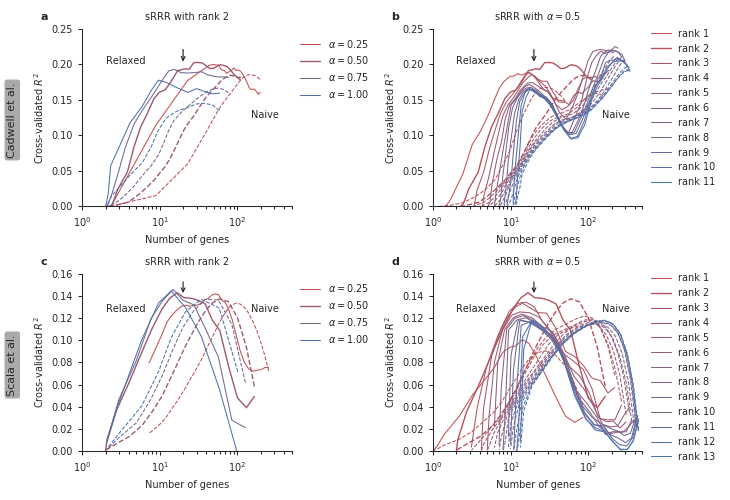

In [386]:
import warnings

sns_styleset()
plt.figure(figsize=(7.3, 5))

ylims = [.25, .16]
relypos = [.2, .125]

for datasetnum, cvresults in enumerate([cvresultsCadwell, cvresultsScala]):

    plt.subplot(2,2,datasetnum*2+1)
    colA = np.array([76, 114, 176]) / 256
    colB = np.array([196, 78, 82])  / 256
    for alphaid in range(4):
        # suppressing "mean of empty slice" warnings
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            n = np.nanmean(cvresults[2][2], axis=(0,1))
            c = np.nanmean(cvresults[2][0], axis=(0,1))
            cr = np.nanmean(cvresults[2][1], axis=(0,1))
        
        if alphaid==1:
            lw = 1
        else:
            lw = .75
        col = (colA * alphaid/3 + colB * (3-alphaid)/3)
        plt.plot(n[:,alphaid], cr[:,alphaid], linewidth=lw, color=col, 
                 label=r'$\alpha={:.2f}$'.format(alphas[alphaid]))
        plt.plot(n[:,alphaid], c[:,alphaid], '--', linewidth=lw, color=col)

    plt.legend(frameon=False, bbox_to_anchor=(1, 1))
    plt.xscale('log')
    plt.xlabel('Number of genes')
    plt.ylabel(r'Cross-validated $R^2$')
    plt.title('sRRR with rank 2')
    plt.ylim([0, ylims[datasetnum]])
    plt.xlim([1, 500])
    plt.text(2, relypos[datasetnum], 'Relaxed', fontsize=7)
    plt.text(150,.125, 'Naive', fontsize=7)

    plt.subplot(2,2,datasetnum*2+2)
    colA = np.array([76, 114, 176]) / 256
    colB = np.array([196, 78, 82])  / 256
    maxRank = len(cvresults)
    for rank in range(1,maxRank+1):
        # suppressing "mean of empty slice" warnings
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            n = np.nanmean(cvresults[rank][2], axis=(0,1))
            c = np.nanmean(cvresults[rank][0], axis=(0,1))
            cr = np.nanmean(cvresults[rank][1], axis=(0,1))
    
        if rank==2:
            lw = 1
        else:
            lw = .75
        col = (colA * (rank-1)/(maxRank-1) + colB * (maxRank-rank)/(maxRank-1))
        plt.plot(n[:,1], cr[:,1], color=col, linewidth=lw,
                 label='rank {}'.format(rank))
        plt.plot(n[:,1], c[:,1], '--', color=col, linewidth=lw)

    plt.legend(frameon=False, bbox_to_anchor=(1, 1.05))
    plt.xscale('log')
    plt.xlabel('Number of genes')
    plt.ylabel(r'Cross-validated $R^2$')
    plt.title(r'sRRR with $\alpha={}$'.format(alphas[1]))
    plt.ylim([0, ylims[datasetnum]])
    plt.xlim([1, 500])
    plt.text(2,relypos[datasetnum], 'Relaxed', fontsize=7)
    plt.text(150,.125, 'Naive', fontsize=7)

sns.despine()
plt.tight_layout(rect=(.03,0,1,1))

plt.text(-.2, 1.05,  'a', transform = plt.gcf().get_axes()[0].transAxes, fontsize=8, fontweight='bold')
plt.text(-.2, 1.05,  'b', transform = plt.gcf().get_axes()[1].transAxes, fontsize=8, fontweight='bold')
plt.text(-.2, 1.05,  'c', transform = plt.gcf().get_axes()[2].transAxes, fontsize=8, fontweight='bold')
plt.text(-.2, 1.05,  'd', transform = plt.gcf().get_axes()[3].transAxes, fontsize=8, fontweight='bold')

plt.gcf().text(.01,.27, 'Scala et al.', rotation=90, fontsize=8, va='center', 
               bbox=dict(facecolor='#aaaaaa', boxstyle='round'))
plt.gcf().text(.01,.76, 'Cadwell et al.', rotation=90, fontsize=8, va='center',
               bbox=dict(facecolor='#aaaaaa', boxstyle='round'))

plt.gcf().get_axes()[0].annotate('', xy=(20, 0.2), xytext=(20, 0.225), 
    arrowprops=dict(arrowstyle='->',facecolor='k', edgecolor='k'))
plt.gcf().get_axes()[1].annotate('', xy=(20, 0.2), xytext=(20, 0.225), 
    arrowprops=dict(arrowstyle='->',facecolor='k', edgecolor='k'))
plt.gcf().get_axes()[2].annotate('', xy=(20, 0.14), xytext=(20, 0.155), 
    arrowprops=dict(arrowstyle='->',facecolor='k', edgecolor='k'))
plt.gcf().get_axes()[3].annotate('', xy=(20, 0.14), xytext=(20, 0.155), 
    arrowprops=dict(arrowstyle='->',facecolor='k', edgecolor='k'))

plt.savefig('revision-figures/cv.png', dpi=200)
plt.savefig('revision-figures/cv.pdf')

In [70]:
# plt.figure(figsize=(6,4))
# plt.plot(lambdas, plt.nanmean(cvresultsCadwell[9][2], axis=(0,1)), '.-')
# plt.yscale('log')

## FIGURE: bibiplots in both datasets

<IPython.core.display.Javascript object>


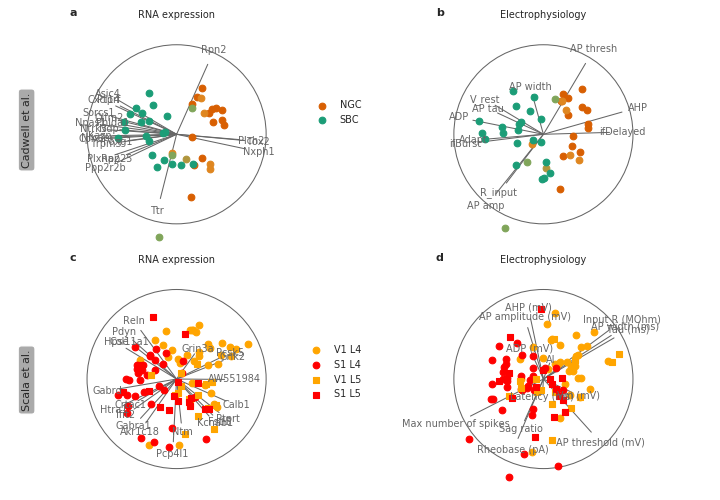

Number of genes selected: 22
Number of genes selected: 20


In [335]:
sns_styleset()
plt.figure(figsize=(7.2, 5))

#################################

X = cadwell['X']
Y = cadwell['Y']
w,v = sparseRRR.relaxed_elastic_rrr(X, Y, rank=2, alpha=.5, lambdau=1.5)
print('Number of genes selected: {}'.format(np.sum(w[:,0]!=0)))

Zx = X @ w[:,:2]
Zy = Y @ v[:,:2]
Zx = Zx / np.std(Zx, axis=0)
Zy = Zy / np.std(Zy, axis=0)
    
plt.subplot(221, aspect='equal')
for ct in np.unique(cadwell['cellTypes']):
    plt.scatter(Zx[cadwell['cellTypes']==ct,0], Zx[cadwell['cellTypes']==ct,1], 
                color=cadwell['colors'][ct], zorder=2, label=cadwell['labels'][ct])
plt.legend(frameon=False, bbox_to_anchor=(1.4, .7))
plt.ylim([-3.6, 3.6])
plt.xlim([-3.6, 3.6])
plt.xticks([])
plt.yticks([])
plt.title('RNA expression')

scaleFactor = 3
L = np.corrcoef(np.concatenate((Zx[:,:2], X), axis=1), rowvar=False)[2:,:2]
for i in np.where(w[:,0]!=0)[0]:
    plt.plot([0, scaleFactor*L[i,0]], [0, scaleFactor*L[i,1]], linewidth=.75, 
             color=[.4, .4, .4], zorder=1)
    plt.text(scaleFactor*L[i,0]*1.2, scaleFactor*L[i,1]*1.2, cadwell['genes'][i], 
             ha='center', va='center', color=[.4, .4, .4], fontsize=7)
circ = plt.Circle((0,0), radius=scaleFactor, color=[.4, .4, .4], fill=False, linewidth=.75)
plt.gca().add_patch(circ)

plt.subplot(222, aspect='equal')
for ct in np.unique(cadwell['cellTypes']):
    plt.scatter(Zy[cadwell['cellTypes']==ct,0], Zy[cadwell['cellTypes']==ct,1], 
                color=cadwell['colors'][ct], zorder=2)
plt.ylim([-3.6, 3.6])
plt.xlim([-3.6, 3.6])
plt.xticks([])
plt.yticks([])
plt.title('Electrophysiology')

L = np.corrcoef(np.concatenate((Zy[:,:2], Y), axis=1), rowvar=False)[2:,:2]
for i in range(Y.shape[1]):
    plt.plot([0, scaleFactor*L[i,0]], [0, scaleFactor*L[i,1]], linewidth=.75, 
             color=[.4, .4, .4], zorder=1)
    plt.text(scaleFactor*L[i,0]*1.2, scaleFactor*L[i,1]*1.2, cadwell['ephysNames'][i], 
             ha='center', va='center', color=[.4, .4, .4], fontsize=7)
circ = plt.Circle((0,0), radius=scaleFactor, color=[.4, .4, .4], fill=False, linewidth=.75)
plt.gca().add_patch(circ)

#################################

X = l4['X']
Y = l4['Y']
w,v = sparseRRR.relaxed_elastic_rrr(X, Y, rank=2, lambdau=.95, alpha=.5)
print('Number of genes selected: {}'.format(np.sum(w[:,0]!=0)))

Zx = X @ w[:,:2]
Zy = Y @ v[:,:2]
Zx = Zx / np.std(Zx, axis=0)
Zy = Zy / np.std(Zy, axis=0)
    
plt.subplot(223, aspect='equal')
# plt.scatter(Zx[l4['regions'][selection]=='V1',0], Zx[l4['regions'][selection]=='V1',1], 
#             color='orange', zorder=2, label='V1')
# plt.scatter(Zx[l4['regions'][selection]=='S1',0], Zx[l4['regions'][selection]=='S1',1], 
#             color='red', zorder=2, label='S1')
plt.scatter(Zx[(l4['regions'][selection]=='V1')&(l4['layers'][selection]==4),0],
            Zx[(l4['regions'][selection]=='V1')&(l4['layers'][selection]==4),1],
            color='orange', zorder=2, label='V1 L4')
plt.scatter(Zx[(l4['regions'][selection]=='S1')&(l4['layers'][selection]==4),0],
            Zx[(l4['regions'][selection]=='S1')&(l4['layers'][selection]==4),1],
            color='red', zorder=2, label='S1 L4')
plt.scatter(Zx[(l4['regions'][selection]=='V1')&(l4['layers'][selection]==5),0],
            Zx[(l4['regions'][selection]=='V1')&(l4['layers'][selection]==5),1],
            color='orange', zorder=2, label='V1 L5', marker='s')
plt.scatter(Zx[(l4['regions'][selection]=='S1')&(l4['layers'][selection]==5),0],
            Zx[(l4['regions'][selection]=='S1')&(l4['layers'][selection]==5),1],
            color='red', zorder=2, label='S1 L5', marker='s')
plt.legend(frameon=False, bbox_to_anchor=(1.4, .7))
plt.ylim([-3.6, 3.6])
plt.xlim([-3.6, 3.6])
plt.xticks([])
plt.yticks([])
plt.title('RNA expression')

scaleFactor = 3
L = np.corrcoef(np.concatenate((Zx[:,:2], X), axis=1), rowvar=False)[2:,:2]
for i in np.where(w[:,0]!=0)[0]:
    plt.plot([0, scaleFactor*L[i,0]], [0, scaleFactor*L[i,1]], linewidth=.75, color=[.4, .4, .4],
             zorder=1)
    plt.text(scaleFactor*L[i,0]*1.2, scaleFactor*L[i,1]*1.2, l4['genes'][l4['genesForRRR']][i], 
             ha='center', va='center', color=[.4, .4, .4], fontsize=7)
circ = plt.Circle((0,0), radius=scaleFactor, color=[.4, .4, .4], fill=False, linewidth=.75)
plt.gca().add_patch(circ)

plt.subplot(224, aspect='equal')
# plt.scatter(Zy[l4['regions'][selection]=='V1',0], Zy[l4['regions'][selection]=='V1',1], 
#             color='orange', zorder=2)
# plt.scatter(Zy[l4['regions'][selection]=='S1',0], Zy[l4['regions'][selection]=='S1',1], 
#             color='red', zorder=2)
plt.scatter(Zy[(l4['regions'][selection]=='V1')&(l4['layers'][selection]==4),0],
            Zy[(l4['regions'][selection]=='V1')&(l4['layers'][selection]==4),1],
            color='orange', zorder=2)
plt.scatter(Zy[(l4['regions'][selection]=='S1')&(l4['layers'][selection]==4),0],
            Zy[(l4['regions'][selection]=='S1')&(l4['layers'][selection]==4),1],
            color='red', zorder=2)
plt.scatter(Zy[(l4['regions'][selection]=='V1')&(l4['layers'][selection]==5),0],
            Zy[(l4['regions'][selection]=='V1')&(l4['layers'][selection]==5),1],
            color='orange', zorder=2, marker='s')
plt.scatter(Zy[(l4['regions'][selection]=='S1')&(l4['layers'][selection]==5),0],
            Zy[(l4['regions'][selection]=='S1')&(l4['layers'][selection]==5),1],
            color='red', zorder=2, marker='s')
plt.ylim([-3.6, 3.6])
plt.xlim([-3.6, 3.6])
plt.xticks([])
plt.yticks([])
plt.title('Electrophysiology')

L = np.corrcoef(np.concatenate((Zy[:,:2], Y), axis=1), rowvar=False)[2:,:2]
for i in range(Y.shape[1]):
    plt.plot([0, scaleFactor*L[i,0]], [0, scaleFactor*L[i,1]], linewidth=.75, color=[.4, .4, .4],
             zorder=1)
    plt.text(scaleFactor*L[i,0]*1.2, scaleFactor*L[i,1]*1.2, l4['ephysNames'][i], 
             ha='center', va='center', color=[.4, .4, .4], fontsize=7)
circ = plt.Circle((0,0), radius=scaleFactor, color=[.4, .4, .4], fill=False, linewidth=.75)
plt.gca().add_patch(circ)

#################################

sns.despine(left=True, bottom=True)
plt.tight_layout()

plt.text(0, 1.05,  'a', transform = plt.gcf().get_axes()[0].transAxes, fontsize=8, fontweight='bold')
plt.text(0, 1.05,  'b', transform = plt.gcf().get_axes()[1].transAxes, fontsize=8, fontweight='bold')
plt.text(0, 1.05,  'c', transform = plt.gcf().get_axes()[2].transAxes, fontsize=8, fontweight='bold')
plt.text(0, 1.05,  'd', transform = plt.gcf().get_axes()[3].transAxes, fontsize=8, fontweight='bold')

plt.gcf().text(.03,.24, 'Scala et al.', rotation=90, fontsize=8, va='center', 
               bbox=dict(facecolor='#aaaaaa', boxstyle='round'))
plt.gcf().text(.03,.74, 'Cadwell et al.', rotation=90, fontsize=8, va='center',
               bbox=dict(facecolor='#aaaaaa', boxstyle='round'))

plt.savefig('revision-figures/bibiplots.png', dpi=200)
plt.savefig('revision-figures/bibiplots.pdf')

## FIGURE: correlations and comparison to Witten/Suo

In [369]:
cvresultsScala,   lambdas, alphas, ranks = pickle.load(open('pickles/cvresults-scala.pickle', 'rb'))
cvresultsCadwell, lambdas, alphas, ranks = pickle.load(open('pickles/cvresults-cadwell.pickle', 'rb'))

In [162]:
X = l4['X']
Y = l4['Y']

lx_scan = np.arange(20, 75, 5)
%time corr_witten_scala, nonz_witten_scala = spls_scca.witten_cv(X, Y, lx_scan, ncomps=2)

lx_scan = np.concatenate((np.arange(.1,1,.1), np.arange(1, 5, .5)))
%time corr_suo_scala, nonz_suo_scala = spls_scca.suo_cv(X, Y, lx_scan)

.......... done
CPU times: user 25.7 s, sys: 100 ms, total: 25.8 s
Wall time: 6.47 s
..

/home/localadmin/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/localadmin/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


........ done
CPU times: user 1h 31min 33s, sys: 40 s, total: 1h 32min 13s
Wall time: 23min 4s


In [167]:
X = cadwell['X']
Y = cadwell['Y']

lx_scan = np.arange(20, 75, 5)
%time corr_witten_cadwell, nonz_witten_cadwell = spls_scca.witten_cv(X, Y, lx_scan, ncomps=2, folds=11)

lx_scan = np.concatenate((np.arange(.1,1,.1), np.arange(1, 5, .5)))
%time corr_suo_cadwell, nonz_suo_cadwell = spls_scca.suo_cv(X, Y, lx_scan, folds=11)

.

/home/localadmin/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/localadmin/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


......... done
CPU times: user 13.1 s, sys: 80 ms, total: 13.2 s
Wall time: 3.3 s
.......... done
CPU times: user 1h 40min 26s, sys: 34 s, total: 1h 41min
Wall time: 25min 16s


In [168]:
corr_witten = [corr_witten_cadwell, corr_witten_scala]
nonz_witten = [nonz_witten_cadwell, nonz_witten_scala]
corr_suo = [corr_suo_cadwell, corr_suo_scala]
nonz_suo = [nonz_suo_cadwell, nonz_suo_scala]

pickle.dump([corr_witten, nonz_witten, corr_suo, nonz_suo], open('pickles/cvresults-wittensuo.pickle', 'wb'))

<IPython.core.display.Javascript object>


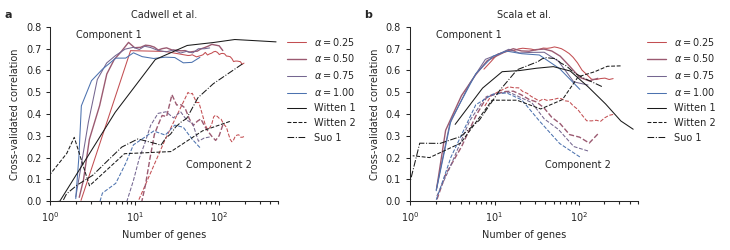

In [383]:
sns_styleset()
plt.figure(figsize=(7.3, 2.5))

titles = ['Cadwell et al.', 'Scala et al.']

for datasetnum, cvresults in enumerate([cvresultsCadwell, cvresultsScala]):

    plt.subplot(1,2,datasetnum+1)
    colA = np.array([76, 114, 176]) / 256
    colB = np.array([196, 78, 82])  / 256
    for alphaid in range(4):
        # suppressing "mean of empty slice" warnings
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            n = np.nanmean(cvresults[2][2], axis=(0,1))
            c = np.nanmean(cvresults[2][4], axis=(0,1))
                    
        if alphaid==1:
            lw = 1
        else:
            lw = .75
        col = (colA * alphaid/3 + colB * (3-alphaid)/3)
        plt.plot(n[:,alphaid], c[:,alphaid,0], linewidth=lw, color=col, 
                 label=r'$\alpha={:.2f}$'.format(alphas[alphaid]))
        plt.plot(n[:,alphaid], c[:,alphaid,1], '--', linewidth=lw, color=col)
        
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
            
        x = np.nanmean(nonz_witten[datasetnum][:,:,:,0], axis=(0,1))
        y = np.nanmean(corr_witten[datasetnum][:,:,:,0], axis=(0,1))
        plt.plot(x[x<500], y[x<500], 'k', linewidth=.75, label='Witten 1')
        x = np.nanmean(nonz_witten[datasetnum][:,:,:,1], axis=(0,1))
        y = np.nanmean(corr_witten[datasetnum][:,:,:,1], axis=(0,1))
        plt.plot(x[x<500], y[x<500], 'k--', linewidth=.75, label='Witten 2')
        x = np.nanmean(nonz_suo[datasetnum][:,:,:], axis=(0,1))
        y = np.nanmean(corr_suo[datasetnum][:,:,:], axis=(0,1))
        plt.plot(x[x<500], y[x<500], 'k-.', linewidth=.75, label='Suo 1')

    plt.legend(frameon=False, bbox_to_anchor=(1, 1))
    plt.xscale('log')
    plt.xlabel('Number of genes')
    plt.ylabel('Cross-validated correlation')
    plt.title(titles[datasetnum])
    plt.ylim([0, .8])
    plt.xlim([1, 500])
    
    plt.text(2, .75, 'Component 1', fontsize=7)
    plt.text(40,.15, 'Component 2', fontsize=7)
    
sns.despine()
plt.tight_layout()

plt.text(-.2, 1.05,  'a', transform = plt.gcf().get_axes()[0].transAxes, fontsize=8, fontweight='bold')
plt.text(-.2, 1.05,  'b', transform = plt.gcf().get_axes()[1].transAxes, fontsize=8, fontweight='bold')

plt.savefig('revision-figures/corr.png', dpi=200)
plt.savefig('revision-figures/corr.pdf')

In [186]:
X = l4['X']
Y = l4['Y']

w,v = spls_scca.witten(X, Y, lx=58)
print(np.sum(w != 0), 'selected genes')

bootCounts = spls_scca.witten_bootstrap(X, Y, lx=58)

for ii in np.argsort(bootCounts)[::-1][:20]:
    print('{:10} {:.2f}'.format(l4['genes'][genesForRRR][ii], bootCounts[ii]))
    
print('')
X = cadwell['X']
Y = cadwell['Y']

w,v = spls_scca.witten(X, Y, lx=53)
print(np.sum(w != 0), 'selected genes')

bootCounts = spls_scca.witten_bootstrap(X, Y, lx=53)

for ii in np.argsort(bootCounts)[::-1][:20]:
    print('{:10} {:.2f}'.format(cadwell['genes'][ii], bootCounts[ii]))

21 selected genes
.................................................................................................... done
Htra1      0.77
Ifit2      0.73
Gabrd      0.71
Akr1c18    0.67
Ifit1      0.63
Gabra1     0.63
Camkv      0.56
Nell1      0.55
Grik2      0.55
AW551984   0.54
Crtac1     0.53
Npnt       0.53
Scn3b      0.52
Calb1      0.52
Rerg       0.51
Pcsk5      0.51
Gsn        0.49
Col11a1    0.48
Pgrmc1     0.47
Syt6       0.46

21 selected genes
.................................................................................................... done
Kazn       0.80
Tox2       0.73
Npas1      0.68
Ntrk3      0.67
Nrcam      0.67
Plch2      0.62
Cplx2      0.61
Tsc22d1    0.59
Nxph1      0.59
Sorcs1     0.57
Arid5a     0.55
Rgs12      0.54
Plxna2     0.53
Npas3      0.52
Olfm2      0.51
Mpped1     0.51
Ppp2r2b    0.51
Cxcl14     0.48
Egln3      0.47
Alcam      0.46


## Fuzik et al. data set 

In [38]:
# LOAD THE DATA FROM THE ORIGINAL FILES

from urllib.request import urlopen
from gzip import GzipFile

# Load gene counts from https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE70844
url = 'ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE70nnn/GSE70844/suppl/GSE70844_Fuzik_et_al_molcounts.xls.gz'
molcounts = pd.read_excel(GzipFile(fileobj=urlopen(url)))
geneNames = np.array(list(molcounts.index))
cells = np.array(list(molcounts))
counts = molcounts.values.astype(np.float).T
ind = [i for i,g in enumerate(geneNames) if g[:5] != 'ERCC-']    # excluding spike ins
geneNames = geneNames[ind]
counts = counts[:,ind]
print('Count table size:', counts.shape)

# Load ephys data
ephys = pd.read_excel('fuzikData/Patch-Seq e-phys ALL.xlsx')
ephysProperties = list(ephys['run_label'][2:])
ephysProperties[18:35] = [a+' OneAP' for a in ephysProperties[18:35]]  # renaming repeated properties
ephysProperties[36:52] = [a+' CRamp' for a in ephysProperties[36:52]]
ephysProperties[53:66] = [a+' THR1' for a in ephysProperties[53:66]]
ephysProperties[67:80] = [a+' THR2' for a in ephysProperties[67:80]]
ephysProperties[81:] = [a+' THR3' for a in ephysProperties[81:]]
rowsExclude = [17, 35, 52, 66, 80]    # empty rows
rowsInclude = np.setdiff1d(np.arange(len(ephysProperties)), rowsExclude)
ephysProperties = np.array(ephysProperties)[rowsInclude]

cellTypes = np.array(ephys.values[1,1:])

ephys[ephys == '-'] = None
ephysData = ephys.values[2:,1:].astype('float')[rowsInclude,:].T
print('Ephys data size:', ephysData.shape)

# Matching gene counts to ephys data (thanks to Shreejoy Tripathy)
matching = pd.read_csv('fuzikData/ephys_expr_matching.csv')
cellsOrder = list(matching['expr_ids'])

print('Cells with sequence data but not matched to ephys:', 
      [c for i,c in enumerate(cells) if c not in cellsOrder])
ind = [i for i,c in enumerate(cells) if c in cellsOrder]
cells = cells[ind]
counts = counts[ind,:]
print('Number of matched cells:', len(ind))

ind = [cellsOrder.index(c) for c in cells]
ephysData = ephysData[ind,:]
cellTypes = cellTypes[ind]

ephysComplete = ~np.isnan(np.sum(ephysData, axis=0))
ephysData = ephysData[:,ephysComplete]
ephysProperties = ephysProperties[ephysComplete]
print('Number of ephys properties available for all cells:', np.sum(ephysComplete))

print('Counts shape:', counts.shape)
print('Ephys shape:', ephysData.shape)

Count table size: (83, 24378)
Ephys data size: (82, 89)
Cells with sequence data but not matched to ephys: ['Run283_L4_C01', 'Run291_L7_E10', 'Run291_L7_D12']
Number of matched cells: 80
Number of ephys properties available for all cells: 80
Counts shape: (80, 24378)
Ephys shape: (80, 80)


In [39]:
# Library size normalization
X = counts / np.sum(counts, axis=1, keepdims=True) * np.median(np.sum(counts, axis=1, keepdims=True))

# Log-transform
X = np.log2(X + 1)

# Sort out cells with nans in the ephys data
ind = ~np.isnan(np.sum(ephysData, axis=1))
X = X[ind, :]
Y = ephysData[ind, :]
cellTypes = cellTypes[ind]

# Sort out genes that are constant zero for the remaining cells
geneNames = geneNames[np.sum(X, axis=0)>0]
X = X[:, np.sum(X, axis=0)>0]

# Standardize X
muX = np.mean(X, axis=0)
X = X - muX
sigma = np.std(X, axis=0)
X = X / sigma

# Standardize Y
mu = np.mean(Y, axis=0)
Y = Y - mu
sigma = np.std(Y, axis=0)
Y = Y / sigma

print('X.shape before feature selection:', X.shape)

# Select genes
geneNames = geneNames[muX>.5]
X = X[:,muX>.5]

print('X.shape:', X.shape)
print('Y.shape:', Y.shape)

X.shape before feature selection: (80, 13089)
X.shape: (80, 1384)
Y.shape: (80, 80)


In [40]:
# Plotting parameters for Fuzik data

cellTypeColors = dict(zip(np.unique(cellTypes), 
                ['#6baed6', '#3182bd', '#08519c', '#fc9272', '#fb6a4a', '#ef3b2c', '#cb181d', '#99000d']))
cellTypeLabels = dict(zip(np.unique(cellTypes), np.unique(cellTypes)))

Genes selected: 21


<IPython.core.display.Javascript object>


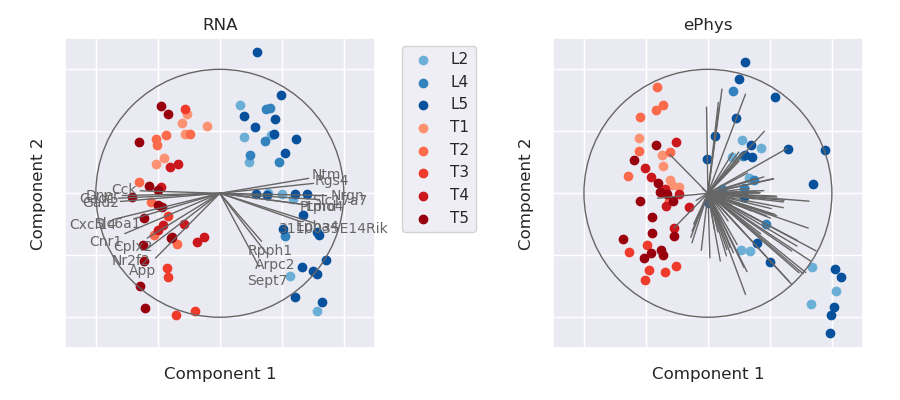

In [129]:
w,v = sparseRRR.relaxed_elastic_rrr(X, Y, rank=2, alpha = .5, lambdau = 2.6)
print('Genes selected: {}'.format(np.sum(w[:,0]!=0)))

sns.set()
sparseRRR.bibiplot(X, Y, w, v, titles=['RNA', 'ePhys'], cellTypes=cellTypes, cellTypeColors=cellTypeColors,
         YdimsNames=['' for i in ephysProperties], YdimsToShow=np.arange(Y.shape[1]), cellTypeLabels = cellTypeLabels,
         XdimsNames=geneNames, xylim = 2.5)

1.......... Time: 0.0h  1m 33s


<IPython.core.display.Javascript object>


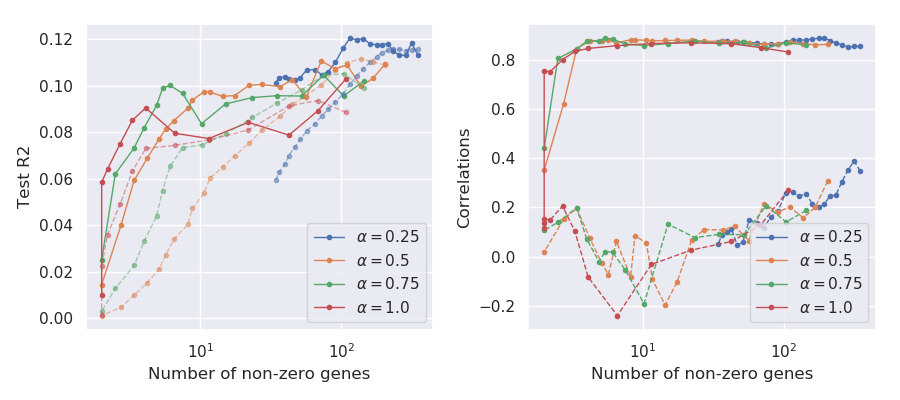

In [130]:
lambdas = np.arange(.1,6,.25)
alphas = np.array([.25, .5, .75, 1])

cvResults = sparseRRR.elastic_rrr_cv(X, Y, rank=2, reps=1, folds=10, alphas=alphas, lambdas=lambdas)
sparseRRR.plot_cv_results(*cvResults, alphas)

In [85]:
lambdas = np.arange(.1,6,.25)
alphas = np.array([.5])
ranks = np.array([1,2])

cvresults = {}
for r in ranks:
    cvresults[r] = sparseRRR.elastic_rrr_cv(X, Y, lambdas=lambdas, alphas=alphas, reps=10, rank=r, folds=10)
    
pickle.dump([cvresults, lambdas, alphas, ranks], open('pickles/cvresults-fuzik.pickle', 'wb'))

1.......... 2.......... 3.......... 4.......... 5.......... 6.......... 7.......... 8.......... 9.......... 10.......... Time: 0.0h  1m 37s
1.......... 2.......... 3.......... 4.......... 5.......... 6.......... 7.......... 8.......... 9.......... 10.......... Time: 0.0h  3m 45s


<IPython.core.display.Javascript object>


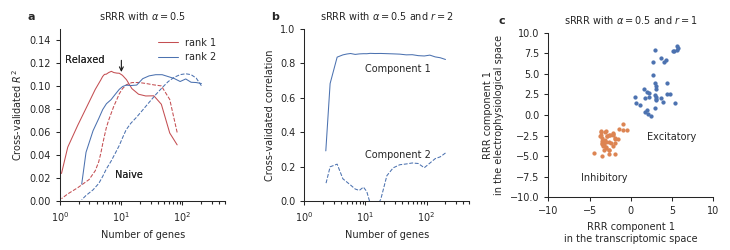

Genes selected: 10


In [140]:
import warnings

sns_styleset()
plt.figure(figsize=(7.3, 2.5))

plt.subplot(131)
cols = ['','r','b']
for rank in range(1,2+1):
    # suppressing "mean of empty slice" warnings
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        n = np.nanmean(cvresults[rank][2], axis=(0,1))
        c = np.nanmean(cvresults[rank][0], axis=(0,1))
        cr = np.nanmean(cvresults[rank][1], axis=(0,1))
    
        plt.plot(n[:,0], cr[:,0], color=cols[rank], linewidth=.75,
                 label='rank {}'.format(rank))
        plt.plot(n[:,0], c[:,0], '--',  color=cols[rank], linewidth=.75)

    plt.legend(frameon=False)#, bbox_to_anchor=(1, 1.05))
    plt.xscale('log')
    plt.xlabel('Number of genes')
    plt.ylabel(r'Cross-validated $R^2$')
    plt.title(r'sRRR with $\alpha=0.5$')
    plt.ylim([0, .15])
    plt.xlim([1, 500])
    plt.text(1.2, .12, 'Relaxed', fontsize=7)
    plt.text(8,.02, 'Naive', fontsize=7)


plt.subplot(132)
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    n = np.nanmean(cvresults[2][2], axis=(0,1))
    c = np.nanmean(cvresults[2][4], axis=(0,1))
    
plt.plot(n[:,0], c[:,0,0], color=cols[2], linewidth=.75,
                 label='rank {}'.format(rank))
plt.plot(n[:,0], c[:,0,1], '--',  color=cols[2], linewidth=.75)

# plt.legend(frameon=False, bbox_to_anchor=(1, 1.05))
plt.xscale('log')
plt.xlabel('Number of genes')
plt.ylabel('Cross-validated correlation')
plt.title(r'sRRR with $\alpha=0.5$ and $r=2$')
plt.ylim([0, 1])
plt.xlim([1, 500])
plt.text(10, .75, 'Component 1', fontsize=7)
plt.text(10,.25, 'Component 2', fontsize=7)


#########
w,v = sparseRRR.relaxed_elastic_rrr(X, Y, rank=1, alpha = .5, lambdau = 2)
print('Genes selected:', np.sum(w!=0))

plt.subplot(133, aspect='equal')
ind = np.isin(cellTypes, ['L5', 'L4', 'L2'])
plt.scatter(X[ind,:]@w, Y[ind,:]@v, s=5)
plt.scatter(X[~ind,:]@w, Y[~ind,:]@v, s=5)
plt.text(2,-3,'Excitatory', fontsize=7)
plt.text(-6,-8,'Inhibitory', fontsize=7)
plt.title(r'sRRR with $\alpha=0.5$ and $r=1$')
plt.xlabel('RRR component 1\nin the transcriptomic space')
plt.ylabel('RRR component 1\nin the electrophysiological space')
plt.xlim([-10,10])
plt.ylim([-10,10])

sns.despine()
plt.tight_layout()

plt.text(-.2, 1.05,  'a', transform = plt.gcf().get_axes()[0].transAxes, fontsize=8, fontweight='bold')
plt.text(-.2, 1.05,  'b', transform = plt.gcf().get_axes()[1].transAxes, fontsize=8, fontweight='bold')
plt.text(-.3, 1.05,  'c', transform = plt.gcf().get_axes()[2].transAxes, fontsize=8, fontweight='bold')

plt.gcf().get_axes()[0].annotate('', xy=(10, 0.11), xytext=(10, 0.125), 
    arrowprops=dict(arrowstyle='->',facecolor='k', edgecolor='k'))

plt.savefig('revision-figures/fuzik.png', dpi=200)
plt.savefig('revision-figures/fuzik.pdf')